In [1]:
import os
import csv

In [2]:
data_dir = "../data"
training_sets_dir = "haspeede2_dev"
training_file = "haspeede2_dev_taskAB.tsv"

In [3]:
train_path = os.path.join(data_dir, training_sets_dir, training_file)

train_set = []

with open(train_path, 'r') as file:
    reader = csv.DictReader(file, delimiter='\t')
    for row in reader:
        train_set.append(row)

In [4]:
train_set[0]

{'id': '2066',
 'text ': 'È terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL ',
 'hs': '0',
 'stereotype': '0'}

In [5]:
hs_corpus = " ".join([document['text '] for document in train_set if document['hs'] == '1'])
clean_corpus = " ".join([document['text '] for document in train_set if document['hs'] == '0'])

In [6]:
hs_corpus[:200]

"@user ...all'invasione di questi animali, e forse è un offesa agli animali, stranieri che arrivano in Italia e solo in Italia?...  @user Piovegovernolad    In  Italia   agli stranieri gli si da anche "

## Visualization with wordcloud

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

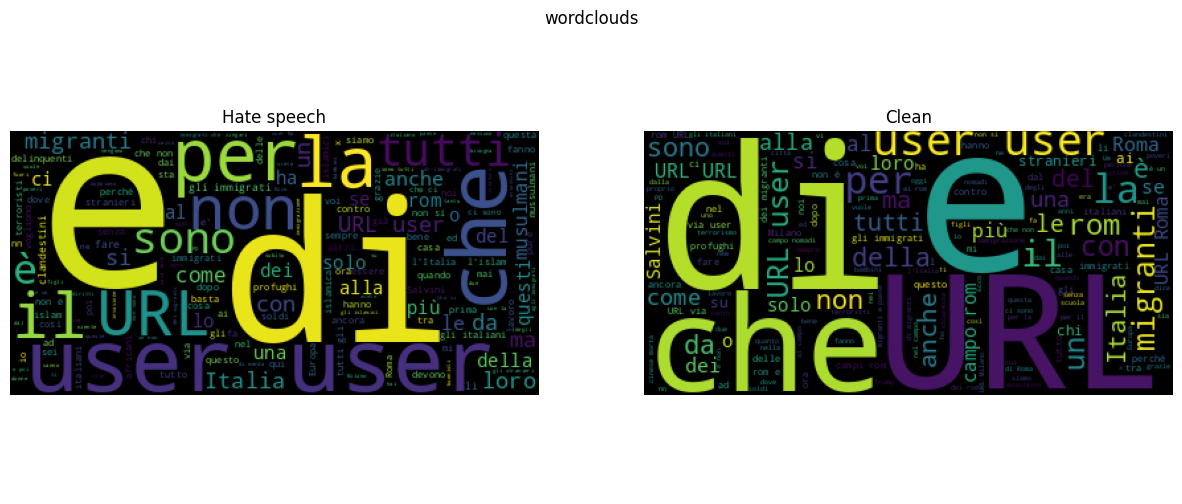

In [8]:
wc_hs = WordCloud().generate_from_text(hs_corpus)
wc_clean = WordCloud().generate_from_text(clean_corpus)

plt.figure(figsize=(15, 6))
plt.axis('off')
plt.title("wordclouds")

plt.subplot(121)
plt.imshow(wc_hs)
plt.title("Hate speech")
plt.axis('off')

plt.subplot(122)
plt.imshow(wc_clean)
plt.title("Clean")
plt.axis('off')
plt.show()

Obviously this is not really informative.
We will use nltk to tokenize the text, delete stopwords and compute frequencies.
As we can see from the previous visualization we should add to the stopwords also token like `user`
and `URL`.

## Preprocessing with nltk

- tokenization
- deletion of stop words
- token frequency

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/fab/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
import string

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/fab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop = list(stopwords.words('italian')) + ['user', 'url']
punctuation = list(string.punctuation) + ['...', '....', '..', '"', "''", '``', '’', '“', '”']

In [13]:
example = "Una frase di esempio per vedere il funzionamento del sistema."

In [14]:
tokens = nltk.word_tokenize(example, language="italian")
tokens2 = [token
           for token in tokens
           if token not in stop + punctuation]
print(tokens)
print(tokens2)

['Una', 'frase', 'di', 'esempio', 'per', 'vedere', 'il', 'funzionamento', 'del', 'sistema', '.']
['Una', 'frase', 'esempio', 'vedere', 'funzionamento', 'sistema']


In [15]:
def preprocess_corpus(corpus):
    tokens = [token
              for token in nltk.word_tokenize(corpus)
              if token.lower() not in stop + punctuation]

    freq_dist = nltk.FreqDist(tokens)

    return freq_dist

In [16]:
freq_dist_hs = preprocess_corpus(hs_corpus)
freq_dist_clean = preprocess_corpus(clean_corpus)

In [17]:
wc_hs = WordCloud().generate_from_frequencies(freq_dist_hs)
wc_clean = WordCloud().generate_from_frequencies(freq_dist_clean)

In [50]:
import random
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 100)

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(120, 40%%, %d%%)" % random.randint(30, 100)

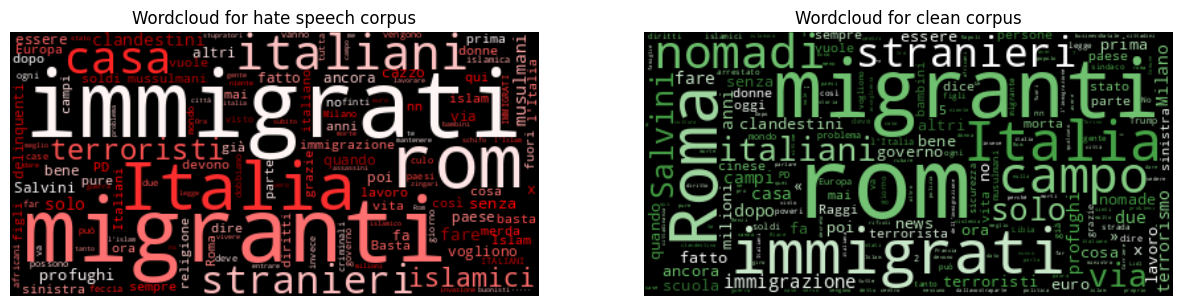

In [51]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wc_hs.recolor(color_func=red_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title("Wordcloud for hate speech corpus")

plt.subplot(1, 2, 2)
plt.imshow(wc_clean.recolor(color_func=green_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title("Wordcloud for clean corpus")

plt.show()

## Most common 20 tokens in the two corpora

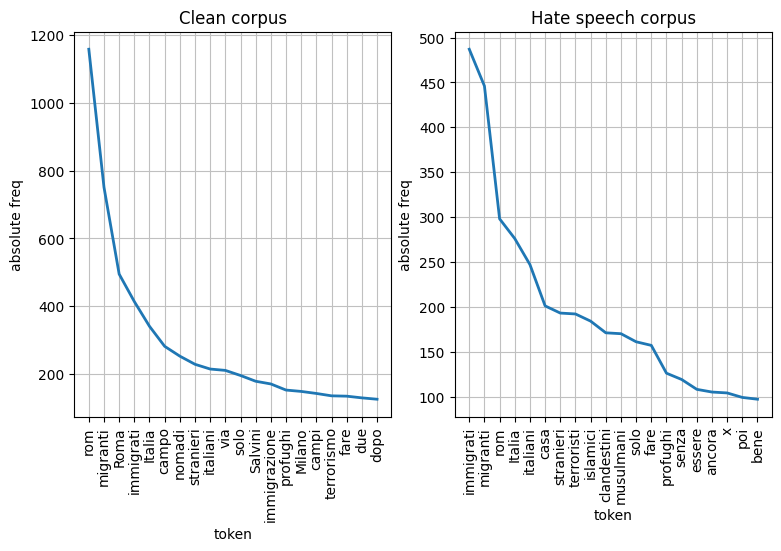

In [19]:
n_most_common = 20
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
freq_dist_clean.plot(n_most_common)
plt.title("Clean corpus")
plt.xlabel("token")
plt.ylabel("absolute freq")

plt.subplot(1, 2, 2)
freq_dist_hs.plot(n_most_common)
plt.title("Hate speech corpus")
plt.xlabel("token")
plt.ylabel("absolute freq")
plt.show()

In [20]:
import pandas as pd
import numpy as np

In [21]:
hs_df = pd.DataFrame(freq_dist_hs.most_common(), columns=['token', 'hs_freq']).set_index('token')
clean_df = pd.DataFrame(freq_dist_clean.most_common(), columns=['token', 'clean_freq']).set_index('token')
df = hs_df.join(clean_df, how="inner")
df.head()

,hs_freq,clean_freq
token,,
immigrati,487,414
migranti,446,751
rom,298,1158
Italia,276,341
italiani,247,215


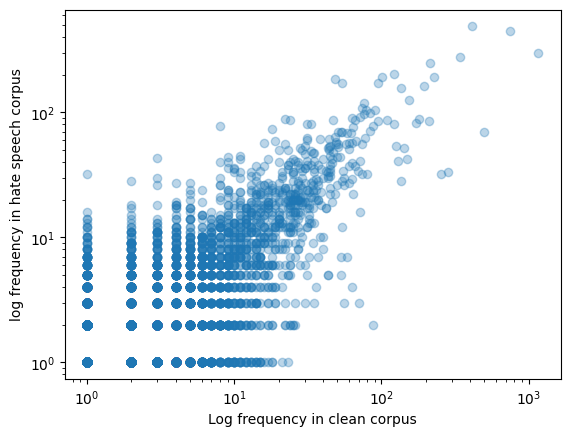

In [22]:
plt.scatter(df['clean_freq'], df['hs_freq'], alpha=.3)
plt.xlabel("Log frequency in clean corpus")
plt.ylabel("log frequency in hate speech corpus")
plt.yscale('log')
plt.xscale('log')